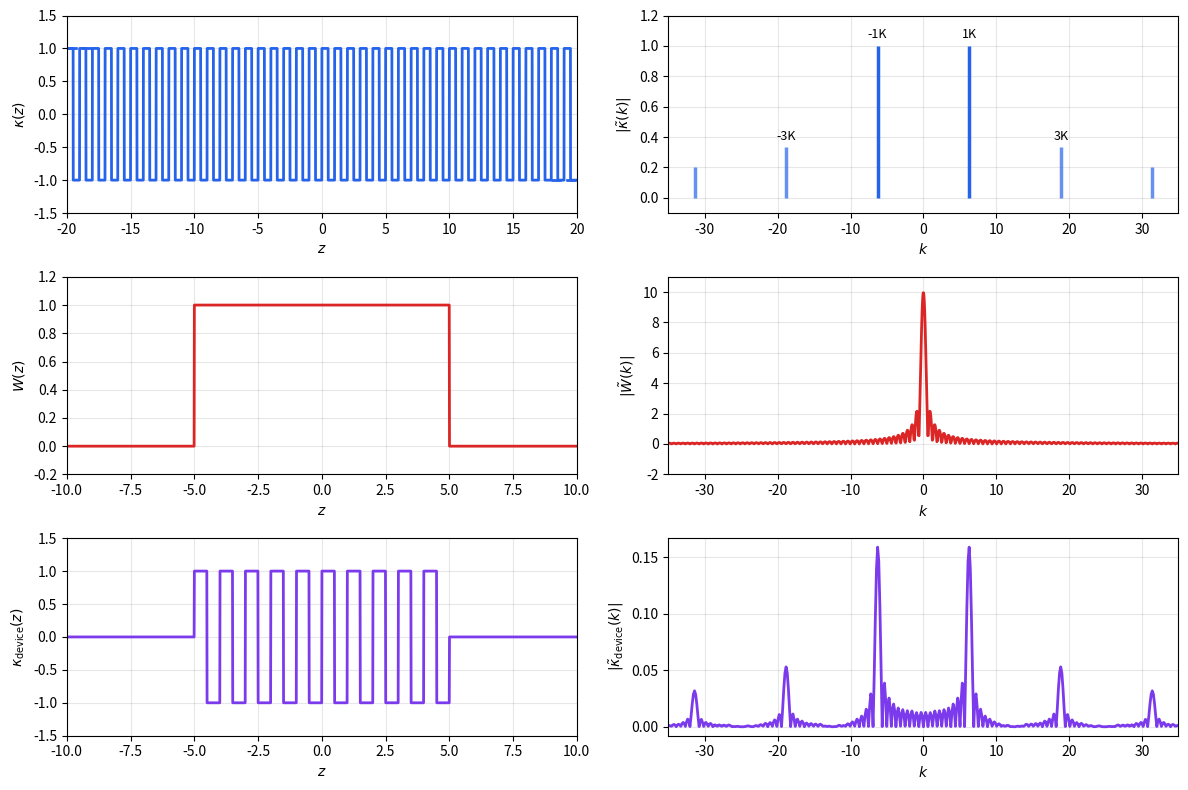

検出されたピークのk値:
[-6.28  6.28]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift, fftfreq

# パラメータ設定
L = 10.0  # デバイス長
Lambda = 1.0  # 分極反転周期
n_points = 2048  # サンプリング点数

# より広い範囲で計算（無限構造を近似）
z_extended = np.linspace(-20*L, 20*L, n_points*40)
z = np.linspace(-L, L, n_points)

# 図の作成
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# カラー設定
color_A = '#2563eb'  # 青
color_B = '#dc2626'  # 赤
color_C = '#7c3aed'  # 紫

# 1段目: 無限周期構造
# 左パネル: 実空間
ax1 = axes[0, 0]
kappa_infinite = np.sign(np.sin(2 * np.pi * z_extended / Lambda))
display_range = 2*L
mask = np.abs(z_extended) < display_range
ax1.plot(z_extended[mask], kappa_infinite[mask], color=color_A, linewidth=2)
ax1.plot([-display_range, -display_range*0.9], [kappa_infinite[mask][0], kappa_infinite[mask][0]],
         '--', color=color_A, linewidth=2)
ax1.plot([display_range*0.9, display_range], [kappa_infinite[mask][-1], kappa_infinite[mask][-1]],
         '--', color=color_A, linewidth=2)
ax1.set_xlim(-display_range, display_range)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$\kappa(z)$')
ax1.grid(True, alpha=0.3)

# 右パネル: 周波数空間
ax2 = axes[0, 1]
K = 2 * np.pi / Lambda

# 表示範囲を調整してより多くのδ関数を表示
k_max = 35
ax2.set_xlim(-k_max, k_max)

# より多くのδ関数を表示
for n in range(-5, 6):
    if n == 0:  # 偶数次は0
        continue
    if n % 2 == 0:  # 偶数はスキップ
        continue
    if abs(n) == 1:
        height = 1.0
        alpha = 1.0
    else:
        height = 1.0 / abs(n)
        alpha = 0.7
    ax2.vlines(n*K, 0, height, colors=color_A, linewidth=2.5, alpha=alpha)
    # 主要な成分にラベル
    if abs(n) <= 3:
        ax2.text(n*K, height + 0.05, f'{n}K', ha='center', fontsize=9)

ax2.set_ylim(-0.1, 1.2)
ax2.set_xlabel(r'$k$')
ax2.set_ylabel(r'$|\tilde{\kappa}(k)|$')
ax2.grid(True, alpha=0.3)

# 2段目: 矩形窓関数
# 左パネル: 実空間
ax2 = axes[1, 0]
window = np.zeros_like(z)
window[np.abs(z) <= L/2] = 1.0
ax2.plot(z, window, color=color_B, linewidth=2)
ax2.set_xlim(-L, L)
ax2.set_ylim(-0.2, 1.2)
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$W(z)$')
ax2.grid(True, alpha=0.3)

# 右パネル: 周波数空間
ax3 = axes[1, 1]
k_sinc = np.linspace(-k_max, k_max, 1000)
sinc_function = L * np.sinc(k_sinc * L / (2 * np.pi))
ax3.plot(k_sinc, np.abs(sinc_function), color=color_B, linewidth=2)
ax3.set_xlim(-k_max, k_max)
ax3.set_ylim(-2, L+1)
ax3.set_xlabel(r'$k$')
ax3.set_ylabel(r'$|\tilde{W}(k)|$')
ax3.grid(True, alpha=0.3)

# 3段目: 有限長デバイス構造
# 左パネル: 実空間
ax4 = axes[2, 0]
kappa_device = np.sign(np.sin(2 * np.pi * z / Lambda))
kappa_device[np.abs(z) > L/2] = 0
ax4.plot(z, kappa_device, color=color_C, linewidth=2)
ax4.set_xlim(-L, L)
ax4.set_ylim(-1.5, 1.5)
ax4.set_xlabel(r'$z$')
ax4.set_ylabel(r'$\kappa_{\mathrm{device}}(z)$')
ax4.grid(True, alpha=0.3)

# 右パネル: 周波数空間（畳み込み結果）
ax6 = axes[2, 1]
z_fft = np.linspace(-2*L, 2*L, 4*n_points)
kappa_fft = np.sign(np.sin(2 * np.pi * z_fft / Lambda))
kappa_fft[np.abs(z_fft) > L/2] = 0
fft_result = fftshift(fft(kappa_fft))
k_fft = fftshift(fftfreq(len(z_fft), z_fft[1] - z_fft[0])) * 2 * np.pi
ax6.plot(k_fft, np.abs(fft_result)/len(z_fft), color=color_C, linewidth=2)
ax6.set_xlim(-k_max, k_max)
ax6.set_xlabel(r'$k$')
ax6.set_ylabel(r'$|\tilde{\kappa}_{\mathrm{device}}(k)|$')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

amplitude_threshold = np.max(
    np.abs(fft_result)/len(z_fft)) * 0.99  # ピーク検出のしきい値
peak_indices = np.where(np.abs(fft_result)/len(z_fft) > amplitude_threshold)[0]
peak_k_values = k_fft[peak_indices]

print("検出されたピークのk値:")
print(np.unique(peak_k_values.round(decimals=2)))  # 重複を排除し、丸めて表示

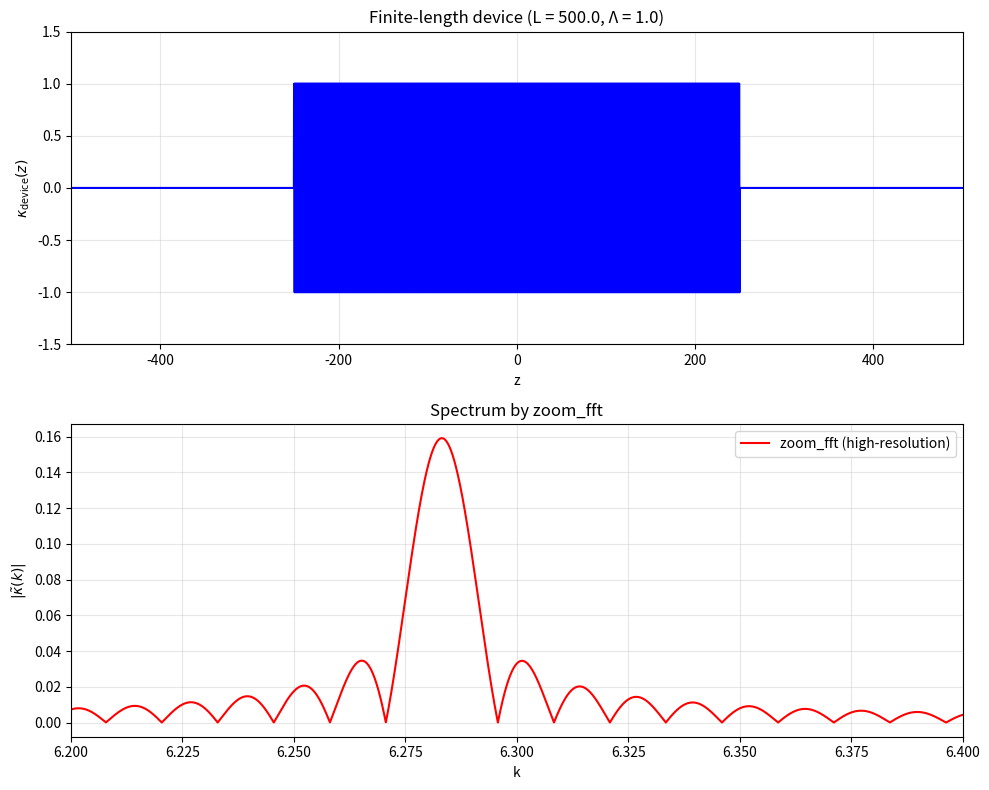

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import zoom_fft

# パラメータ
L = 500.0  # デバイス長
Lambda = 1.0  # 分極反転周期
n_points = 8192  # サンプリング点数

# 注目する波数範囲
k_start = 6.2
k_stop = 6.4
m = 8192  # 計算点数（解像度）

# 位置配列
z = np.linspace(-2*L, 2*L, 4*n_points)
dz = z[1] - z[0]

# 有限長デバイス構造
kappa_device = np.sign(np.sin(2 * np.pi * z / Lambda))
kappa_device[np.abs(z) > L/2] = 0

# zoom_fft計算
fs = 1 / dz  # サンプリング周波数
f_start = k_start / (2 * np.pi)
f_stop = k_stop / (2 * np.pi)
zoom_result = zoom_fft(kappa_device, [f_start, f_stop], m=m, fs=fs)

# 対応する波数配列
k_zoom = np.linspace(k_start, k_stop, m, endpoint=False)

# プロット
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# 1. 実空間のデバイス構造
ax1 = axes[0]
display_z = z[np.abs(z) <= L]
display_kappa = kappa_device[np.abs(z) <= L]
ax1.plot(display_z, display_kappa, 'b-', linewidth=1.5)
ax1.set_xlim(-L, L)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel('z')
ax1.set_ylabel(r'$\kappa_{\mathrm{device}}(z)$')
ax1.grid(True, alpha=0.3)
ax1.set_title(f'Finite-length device (L = {L}, Λ = {Lambda})')

# 2. zoom_fftによるスペクトル解析結果
ax2 = axes[1]
ax2.plot(k_zoom, np.abs(zoom_result) / len(kappa_device),
         'r-', linewidth=1.5, label='zoom_fft (high-resolution)')
ax2.set_xlim(k_start, k_stop)
ax2.set_xlabel('k')
ax2.set_ylabel(r'$|\tilde{\kappa}(k)|$')
ax2.grid(True, alpha=0.3)
ax2.set_title('Spectrum by zoom_fft')
ax2.legend()

plt.tight_layout()
plt.show()

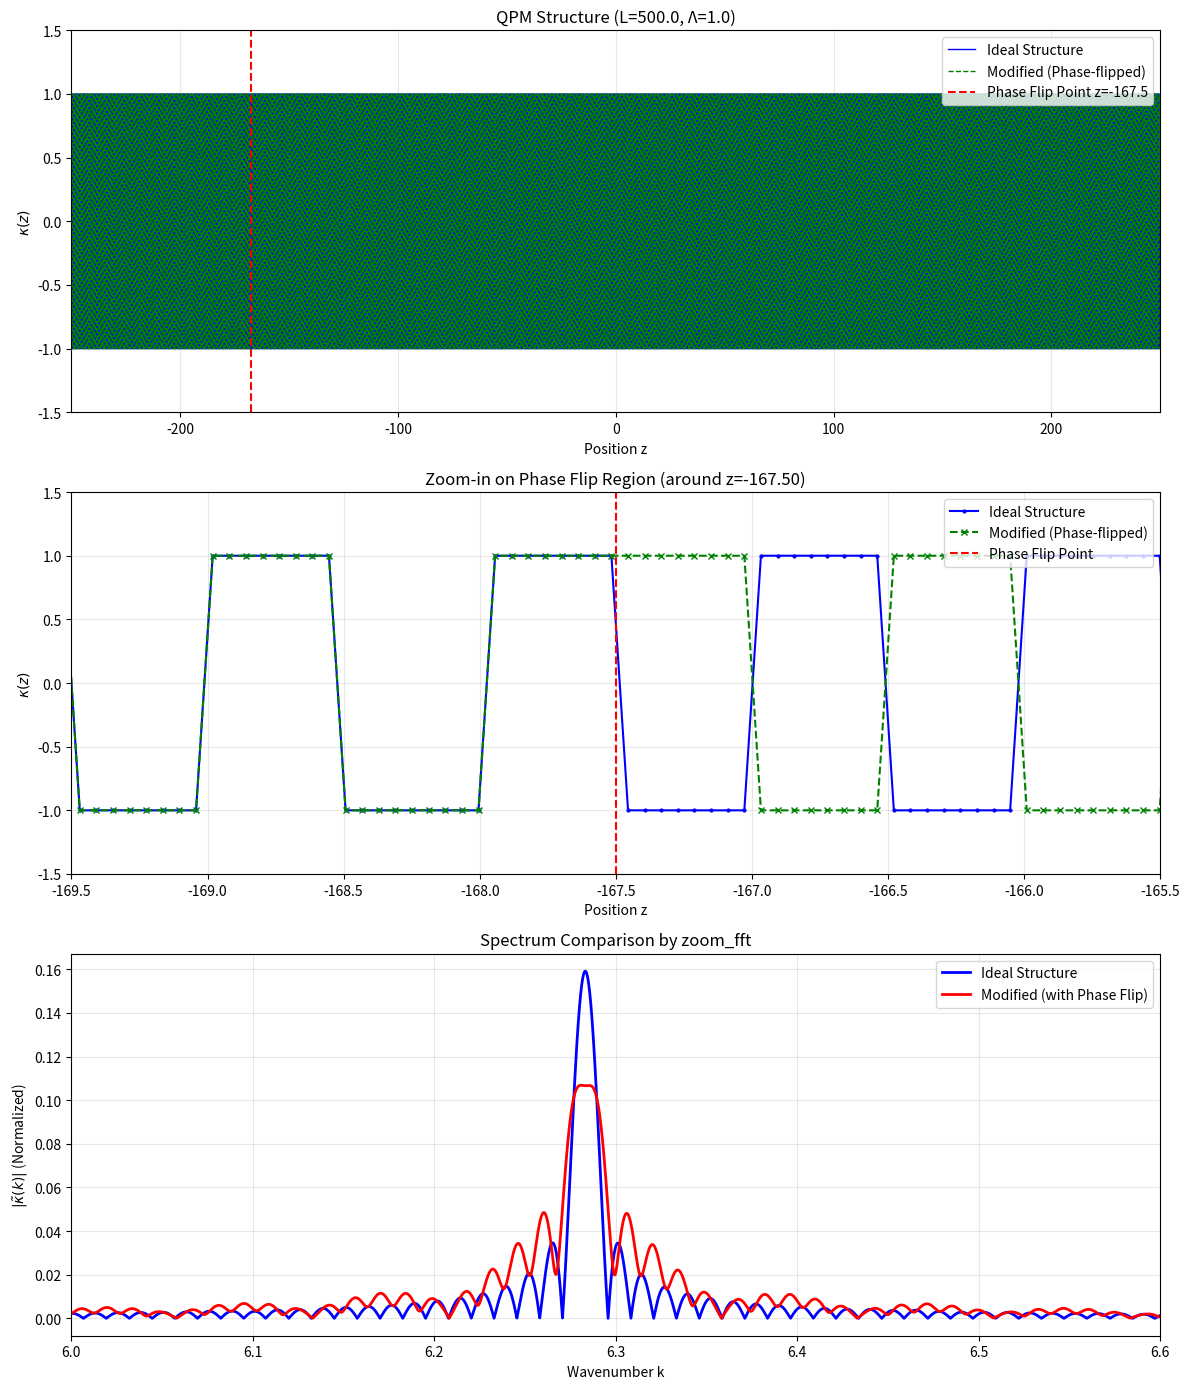

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import zoom_fft

# パラメータ設定
L = 500.0          # デバイス長
Lambda = 1.0       # 分極反転周期
n_points = 8192    # サンプリング点数

# 注目する波数範囲
k_start = 6.0
k_stop = 6.6
m = 8192

# 空間座標の生成
z = np.linspace(-2*L, 2*L, 4*n_points)
dz = z[1] - z[0]

# 1. 理想的なQPM周期構造
kappa_periodic = np.sign(np.sin(2 * np.pi * z / Lambda))

# 2. 位相エラーを持つ構造の生成
kappa_modified_periodic = kappa_periodic.copy()
z_defect = 0.165 * L - L/2  # z = 82.5
kappa_modified_periodic[z > z_defect] *= -1  # 位相反転

# 3. 有限長デバイスにする
window = np.zeros_like(z)
window[np.abs(z) <= L/2] = 1
kappa_ideal = kappa_periodic * window
kappa_modified = kappa_modified_periodic * window

# zoom_fft計算
fs = 1 / dz
f_start = k_start / (2 * np.pi)
f_stop = k_stop / (2 * np.pi)
zoom_ideal = zoom_fft(kappa_ideal, [f_start, f_stop], m=m, fs=fs)
zoom_modified = zoom_fft(kappa_modified, [f_start, f_stop], m=m, fs=fs)

# 対応する波数配列
k_zoom = np.linspace(k_start, k_stop, m, endpoint=False)

# プロット
fig, axes = plt.subplots(3, 1, figsize=(12, 14))
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# 1. デバイス構造全体
ax1 = axes[0]
ax1.plot(z, kappa_ideal, 'b-', lw=1, label='Ideal Structure')
ax1.plot(z, kappa_modified, 'g--', lw=1, label='Modified (Phase-flipped)')
ax1.set_xlim(-L/2, L/2)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel('Position z')
ax1.set_ylabel(r'$\kappa(z)$')
ax1.set_title(f'QPM Structure (L={L}, Λ={Lambda})')
ax1.axvline(x=z_defect, color='red', linestyle='--',
            label=f'Phase Flip Point z={z_defect}')
ax1.legend(loc='upper right')

# 2. 位相反転部分の拡大図
ax2 = axes[1]
ax2.plot(z, kappa_ideal, 'b-', marker='.', ms=4, label='Ideal Structure')
ax2.plot(z, kappa_modified, 'g--', marker='x',
         ms=4, label='Modified (Phase-flipped)')
ax2.set_xlim(z_defect - 2*Lambda, z_defect + 2*Lambda)
ax2.set_ylim(-1.5, 1.5)
ax2.set_xlabel('Position z')
ax2.set_ylabel(r'$\kappa(z)$')
ax2.set_title(f'Zoom-in on Phase Flip Region (around z={z_defect:.2f})')
ax2.axvline(x=z_defect, color='red', linestyle='--', label=f'Phase Flip Point')
ax2.legend(loc='upper right')

# 3. zoom_fftによるスペクトル解析結果の比較
ax3 = axes[2]
ax3.plot(k_zoom, np.abs(zoom_ideal) / len(z),
         'b-', lw=2, label='Ideal Structure')
ax3.plot(k_zoom, np.abs(zoom_modified) / len(z),
         'r-', lw=2, label='Modified (with Phase Flip)')
ax3.set_xlim(k_start, k_stop)
ax3.set_xlabel('Wavenumber k')
ax3.set_ylabel(r'$|\tilde{\kappa}(k)|$ (Normalized)')
ax3.set_title('Spectrum Comparison by zoom_fft')
ax3.legend()

plt.tight_layout()
plt.show()

## 有限長矩形波の和を用いたスペクトル解析

### 1. 解析対象の関数と、その分解（空間領域）

今回解析する関数 $f(z)$ は、区間 $[-L/2, L/2]$ において定義され、点 $z_d$ を境に符号が反転する有限長の矩形波である。

この関数 $f(z)$ は、以下の2つのより単純な関数の和として厳密に表現できる：

ここで、周期 $\Lambda$ の無限周期矩形波を $p(z)$ とする。

$$f(z) = g(z) + h(z)$$

#### 関数A：基準となる有限長矩形波 $g(z)$
- **定義：** $g(z) = p(z) \times W_L(z)$
- **説明：** 無限周期矩形波 $p(z)$ に、幅 $L$ の矩形窓関数 $W_L(z)$ を乗算したもの
  
$$W_L(z) = \begin{cases}
1 & \text{if } -L/2 \leq z \leq L/2 \\
0 & \text{otherwise}
\end{cases}$$

#### 関数B：差分を補正する矩形波 $h(z)$
- **定義：** $h(z) = -2p(z) \times W_d(z)$
- **説明：** 振幅を$-2$倍した無限周期矩形波に、幅 $(L/2 - z_d)$ の短い矩形窓関数 $W_d(z)$ を乗算したもの

$$W_d(z) = \begin{cases}
1 & \text{if } z_d \leq z \leq L/2 \\
0 & \text{otherwise}
\end{cases}$$

### 2. スペクトルの導出と重ね合わせ（周波数領域）

フーリエ変換の線形性により、$f(z)$ のスペクトル $F(k)$ は：

$$F(k) = G(k) + H(k)$$

ここで、$G(k) = \mathcal{F}[g(z)]$、$H(k) = \mathcal{F}[h(z)]$ である。

各スペクトルは畳み込み定理を用いて計算される：

#### スペクトルA：$G(k)$
- **計算：** $G(k) = \mathcal{F}[p(z)] * \mathcal{F}[W_L(z)]$ （$*$は畳み込み）
- **構成要素：**
  - $\mathcal{F}[p(z)]$：基本波数 $k_q = 2\pi/\Lambda$ とその奇数次高調波の位置に立つデルタ関数の列
  - $\mathcal{F}[W_L(z)]$：幅 $L$ の窓に対応するsinc関数

#### スペクトルB：$H(k)$
- **計算：** $H(k) = \mathcal{F}[-2p(z)] * \mathcal{F}[W_d(z)]$
- **構成要素：**
  - $\mathcal{F}[-2p(z)]$：振幅が$-2$倍されたデルタ関数の列
  - $\mathcal{F}[W_d(z)]$：短い窓に対応する幅の広いsinc関数

### 3. スペクトルの干渉と形状制御

この解析の核心は、$F(k)$ が2つの**複素数の波（らせん）**である $G(k)$ と $H(k)$ のベクトル的な和、すなわち「らせんの合体」として表現される点にある。

$f(z)$ を $g(z)$ と $h(z)$ に分解するという一見単純な操作は、最終的に得たいスペクトル形状 $F(k)$ を実現するために、2つの構成要素 $G(k)$ と $H(k)$ の干渉を意図的に設計することを意味する。

この2つのらせん $G(k)$ と $H(k)$ は、それぞれ異なる位相構造（ねじれ方）を持っているため、ベクトルとして足し合わせると、波数 $k$ の各点において精巧な打ち消し合い（位相干渉）が生じる。この「合体」の結果、生成される新しいらせん $F(k)$ は、特定の波数領域において、その**半径（絶対値 $|F(k)|$）がほぼ一定に保たれる**という特徴的な性質を持つ。

この半径が一定であるという事実こそが、スペクトルの絶対値を取ってプロットした際に観測される、平坦で**広帯域な分布**の直接的な起源である。

したがって、$f(z)$ の持つ特徴的なスペクトル形状は、2つのより単純な構造のスペクトルが、複素数の波として線形的に重ね合わさった結果生じる、必然的な物理的帰結として明快に説明される。

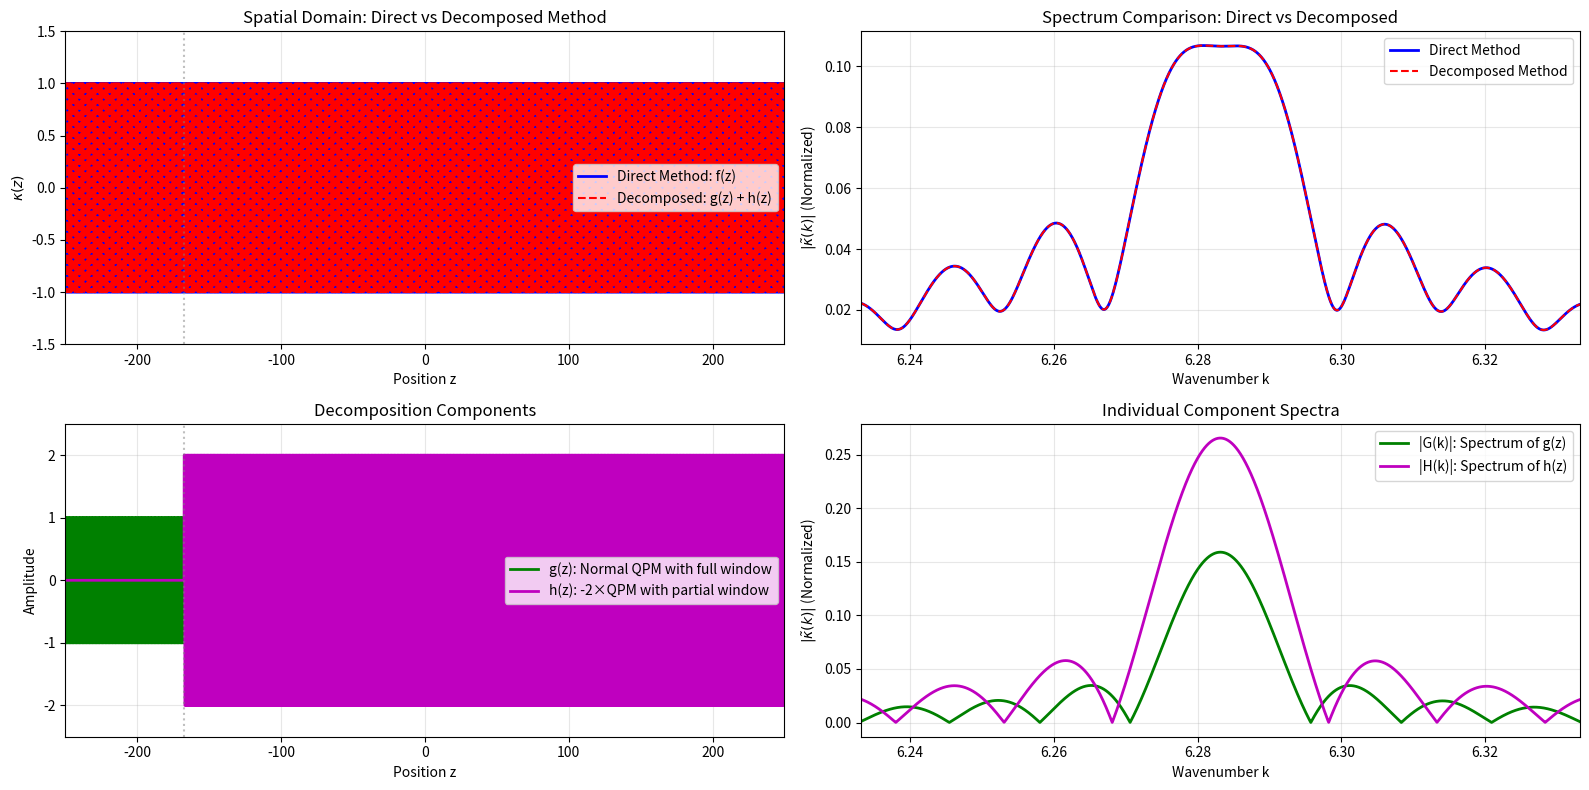

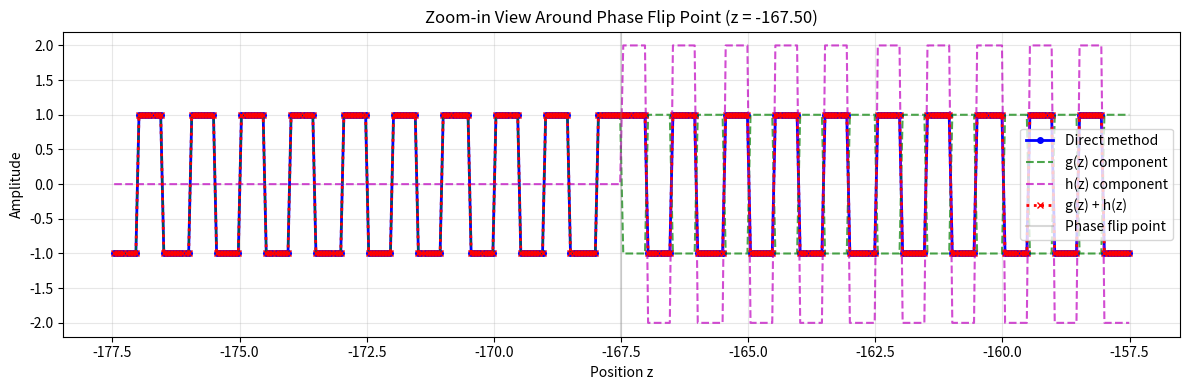

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import zoom_fft

# パラメータ設定
L = 500.0          # デバイス長
Lambda = 1.0       # 分極反転周期
n_points = 8192    # サンプリング点数

# 注目する波数範囲
k_range = 0.05
k_start = 2*np.pi - k_range
k_stop = 2*np.pi + k_range
m = 8192

# 空間座標の生成
z = np.linspace(-2*L, 2*L, 4*n_points)
dz = z[1] - z[0]

# 1. 通常の方法（直接計算）
kappa_periodic = np.sign(np.sin(2 * np.pi * z / Lambda))
kappa_modified_periodic = kappa_periodic.copy()
z_defect = 0.165 * L - L/2  # z = 82.5
kappa_modified_periodic[z > z_defect] *= -1

window_full = np.zeros_like(z)
window_full[np.abs(z) <= L/2] = 1
kappa_modified = kappa_modified_periodic * window_full

# 2. 分解による方法
g_z = kappa_periodic * window_full  # 通常のQPM構造

window_d = np.zeros_like(z)
window_d[(z >= z_defect) & (z <= L/2)] = 1
h_z = -2 * kappa_periodic * window_d  # 位相反転部分の補正項

# zoom_fft計算
fs = 1 / dz
f_start = k_start / (2 * np.pi)
f_stop = k_stop / (2 * np.pi)

zoom_direct = zoom_fft(kappa_modified, [f_start, f_stop], m=m, fs=fs)
zoom_g = zoom_fft(g_z, [f_start, f_stop], m=m, fs=fs)
zoom_h = zoom_fft(h_z, [f_start, f_stop], m=m, fs=fs)
zoom_decomposed = zoom_g + zoom_h

k_zoom = np.linspace(k_start, k_stop, m, endpoint=False)
norm_factor = len(z)

# プロット
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# 実空間での一致確認
f_z_decomposed = g_z + h_z

# 1. 空間領域での構造比較
ax1 = axes[0, 0]
ax1.plot(z, kappa_modified, 'b-', lw=2, label='Direct Method: f(z)')
ax1.plot(z, f_z_decomposed, 'r--', lw=1.5, label='Decomposed: g(z) + h(z)')
ax1.set_xlim(-L/2, L/2)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel('Position z')
ax1.set_ylabel(r'$\kappa(z)$')
ax1.set_title('Spatial Domain: Direct vs Decomposed Method')
ax1.axvline(x=z_defect, color='gray', linestyle=':', alpha=0.5)
ax1.legend()

# 2. 分解成分の表示
ax2 = axes[1, 0]
ax2.plot(z, g_z, 'g-', lw=2, label='g(z): Normal QPM with full window')
ax2.plot(z, h_z, 'm-', lw=2, label='h(z): -2×QPM with partial window')
ax2.set_xlim(-L/2, L/2)
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Position z')
ax2.set_ylabel('Amplitude')
ax2.set_title('Decomposition Components')
ax2.axvline(x=z_defect, color='gray', linestyle=':', alpha=0.5)
ax2.legend()

# 3. スペクトル比較
ax3 = axes[0, 1]
ax3.plot(k_zoom, np.abs(zoom_direct) / norm_factor, 'b-', lw=2,
         label='Direct Method')
ax3.plot(k_zoom, np.abs(zoom_decomposed) / norm_factor, 'r--', lw=1.5,
         label='Decomposed Method')
ax3.set_xlim(k_start, k_stop)
ax3.set_xlabel('Wavenumber k')
ax3.set_ylabel(r'$|\tilde{\kappa}(k)|$ (Normalized)')
ax3.set_title('Spectrum Comparison: Direct vs Decomposed')
ax3.legend()

# 4. 分解成分のスペクトル
ax4 = axes[1, 1]
ax4.plot(k_zoom, np.abs(zoom_g) / norm_factor, 'g-', lw=2,
         label='|G(k)|: Spectrum of g(z)')
ax4.plot(k_zoom, np.abs(zoom_h) / norm_factor, 'm-', lw=2,
         label='|H(k)|: Spectrum of h(z)')
ax4.set_xlim(k_start, k_stop)
ax4.set_xlabel('Wavenumber k')
ax4.set_ylabel(r'$|\tilde{\kappa}(k)|$ (Normalized)')
ax4.set_title('Individual Component Spectra')
ax4.legend()

plt.tight_layout()
plt.show()

# 位相反転領域の拡大図
fig2, ax5 = plt.subplots(1, 1, figsize=(12, 4))
zoom_range = 10 * Lambda
z_zoom_idx = np.where((z >= z_defect - zoom_range) & (z <= z_defect + zoom_range))

ax5.plot(z[z_zoom_idx], kappa_modified[z_zoom_idx], 'b-', lw=2,
         marker='o', ms=4, label='Direct method')
ax5.plot(z[z_zoom_idx], g_z[z_zoom_idx], 'g--', lw=1.5,
         alpha=0.7, label='g(z) component')
ax5.plot(z[z_zoom_idx], h_z[z_zoom_idx], 'm--', lw=1.5,
         alpha=0.7, label='h(z) component')
ax5.plot(z[z_zoom_idx], f_z_decomposed[z_zoom_idx], 'r:', lw=2,
         marker='x', ms=4, label='g(z) + h(z)')
ax5.axvline(x=z_defect, color='gray', linestyle='-',
            alpha=0.3, label='Phase flip point')
ax5.set_xlabel('Position z')
ax5.set_ylabel('Amplitude')
ax5.set_title(f'Zoom-in View Around Phase Flip Point (z = {z_defect:.2f})')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
import plotly.graph_objects as go
import numpy as np

# wavenumberの表示範囲を指定（必要に応じて変更）
k_display_range = 0.05
k_display_start = 2*np.pi-k_display_range
k_display_stop = 2*np.pi+k_display_range

# 表示範囲のインデックスを取得
k_indices = np.where((k_zoom >= k_display_start) & (k_zoom <= k_display_stop))[0]

# 表示用のデータを抽出
k_plot = k_zoom[k_indices]
g_plot = (zoom_g / norm_factor)[k_indices]
h_plot = (zoom_h / norm_factor)[k_indices]
sum_plot = (zoom_decomposed / norm_factor)[k_indices]

# データ間引き（オプション：プロットを軽くしたい場合）
skip = 2  # 1なら間引きなし、2なら半分、など
k_plot = k_plot[::skip]
g_plot = g_plot[::skip]
h_plot = h_plot[::skip]
sum_plot = sum_plot[::skip]

# 3D螺旋プロット作成
fig_3d = go.Figure()

# G(k)の螺旋
fig_3d.add_trace(go.Scatter3d(
    x=k_plot,
    y=g_plot.real,
    z=g_plot.imag,
    mode='lines',
    name='G(k)',
    line=dict(color='green', width=4),
    showlegend=True,
    hovertemplate='k=%{x:.3f}<br>Real=%{y:.4f}<br>Imag=%{z:.4f}<extra></extra>'
))

# H(k)の螺旋
fig_3d.add_trace(go.Scatter3d(
    x=k_plot,
    y=h_plot.real,
    z=h_plot.imag,
    mode='lines',
    name='H(k)',
    line=dict(color='magenta', width=4),
    showlegend=True,
    hovertemplate='k=%{x:.3f}<br>Real=%{y:.4f}<br>Imag=%{z:.4f}<extra></extra>'
))

# G(k) + H(k)の螺旋
fig_3d.add_trace(go.Scatter3d(
    x=k_plot,
    y=sum_plot.real,
    z=sum_plot.imag,
    mode='lines',
    name='G(k) + H(k)',
    line=dict(color='red', width=6),
    showlegend=True,
    hovertemplate='k=%{x:.3f}<br>Real=%{y:.4f}<br>Imag=%{z:.4f}<extra></extra>'
))

# 始点と終点にマーカーを追加
for data, color, name in [(g_plot, 'green', 'G'), (h_plot, 'magenta', 'H'), (sum_plot, 'red', 'Sum')]:
    # 始点
    fig_3d.add_trace(go.Scatter3d(
        x=[k_plot[0]],
        y=[data[0].real],
        z=[data[0].imag],
        mode='markers',
        marker=dict(size=8, color=color),
        showlegend=False,
        hovertext=f'{name} Start (k={k_plot[0]:.3f})'
    ))
    # 終点
    fig_3d.add_trace(go.Scatter3d(
        x=[k_plot[-1]],
        y=[data[-1].real],
        z=[data[-1].imag],
        mode='markers',
        marker=dict(size=8, color=color, symbol='square'),
        showlegend=False,
        hovertext=f'{name} End (k={k_plot[-1]:.3f})'
    ))

# 原点に補助線を追加
fig_3d.add_trace(go.Scatter3d(
    x=[k_plot[0], k_plot[-1]],
    y=[0, 0],
    z=[0, 0],
    mode='lines',
    line=dict(color='gray', width=2, dash='dash'),
    showlegend=False,
    name='Real axis'
))

# レイアウト設定
fig_3d.update_layout(
    title={
        'text': f'3D Complex Spiral Plot: k ∈ [{k_display_start:.2f}, {k_display_stop:.2f}]',
        'x': 0.5,
        'xanchor': 'center'
    },
    scene=dict(
        xaxis_title='Wavenumber k',
        yaxis_title='Real Part',
        zaxis_title='Imaginary Part',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='manual',
        aspectratio=dict(x=2, y=1, z=1)
    ),
    width=900,
    height=700,
    showlegend=True,
    legend=dict(
        x=0.7,
        y=0.9
    )
)

# プロットを表示
fig_3d.show()

# 情報表示（オプション）
print(
    f"Displayed wavenumber range: [{k_display_start:.3f}, {k_display_stop:.3f}]")
print(f"Number of points: {len(k_plot)}")
print(f"Data skip factor: {skip}")

Displayed wavenumber range: [6.233, 6.333]
Number of points: 4096
Data skip factor: 2


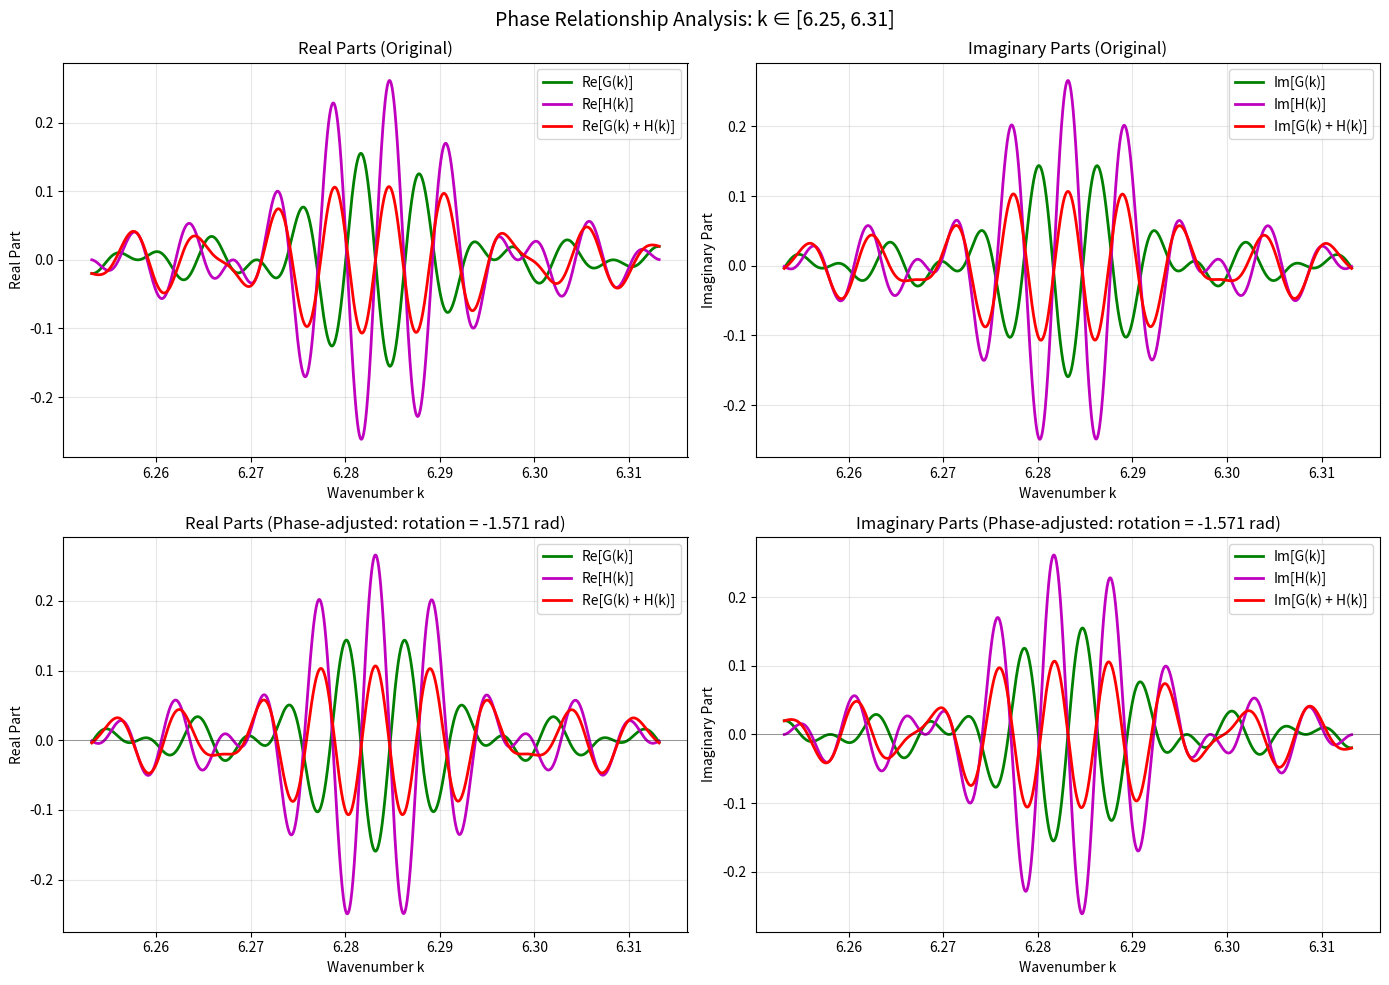

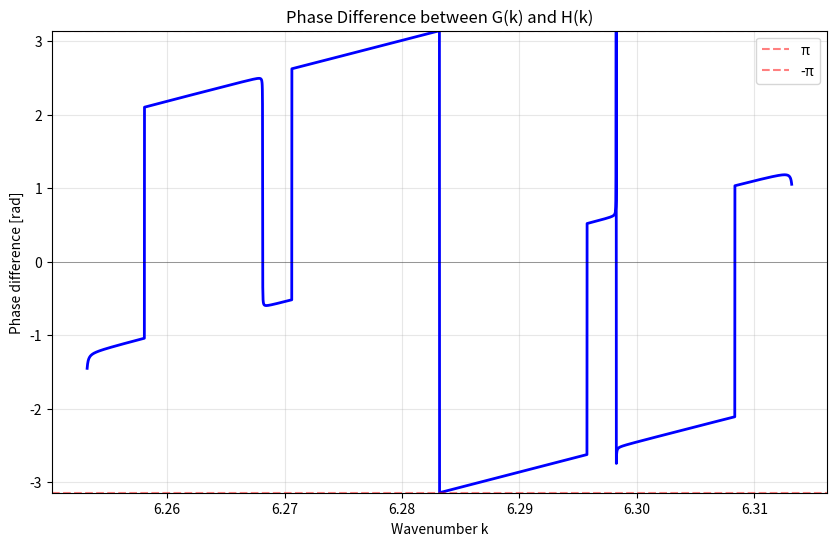


位相調整情報:
調整方法: h_imag_zero
回転角度: -1.571 rad (-90.0°)
基準波数における位相差 (G-H): 3.142 rad


In [ ]:
# 表示範囲の再設定（必要に応じて変更）
k_phase_range = 0.03
k_phase_start = 2*np.pi-k_phase_range
k_phase_stop = 2*np.pi+k_phase_range

# 表示範囲のインデックスを取得
k_phase_indices = np.where((k_zoom >= k_phase_start) & (k_zoom <= k_phase_stop))[0]

# データを抽出
k_phase = k_zoom[k_phase_indices]
g_phase = (zoom_g / norm_factor)[k_phase_indices]
h_phase = (zoom_h / norm_factor)[k_phase_indices]
sum_phase = (zoom_decomposed / norm_factor)[k_phase_indices]

# 位相調整方法の選択
phase_adjustment_mode = "h_imag_zero"  # "h_imag_zero" or "reference_point"

rotation_angle=0
if phase_adjustment_mode == "h_imag_zero":
    # 方法1: H(k)の虚部が全体的にゼロに近くなるような位相回転
    # H(k)の平均的な位相を計算
    h_phase_angle = np.angle(h_phase)
    # 中央付近の位相を基準にする
    ref_idx = len(h_phase) // 2
    rotation_angle = -h_phase_angle[ref_idx]
    
elif phase_adjustment_mode == "reference_point":
    # 方法2: 特定の波数での位相を基準にする
    ref_k = (k_phase_start + k_phase_stop) / 2
    ref_idx = np.argmin(np.abs(k_phase - ref_k))
    rotation_angle = -np.angle(h_phase[ref_idx])

# 位相回転を適用
phase_factor = np.exp(1j * rotation_angle)
g_rotated = g_phase * phase_factor
h_rotated = h_phase * phase_factor
sum_rotated = sum_phase * phase_factor

# プロット作成
fig_phase, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 実部のプロット（位相調整前）
ax1 = axes[0, 0]
ax1.plot(k_phase, g_phase.real, 'g-', lw=2, label='Re[G(k)]')
ax1.plot(k_phase, h_phase.real, 'm-', lw=2, label='Re[H(k)]')
ax1.plot(k_phase, sum_phase.real, 'r-', lw=2, label='Re[G(k) + H(k)]')
ax1.set_xlabel('Wavenumber k')
ax1.set_ylabel('Real Part')
ax1.set_title('Real Parts (Original)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 虚部のプロット（位相調整前）
ax2 = axes[0, 1]
ax2.plot(k_phase, g_phase.imag, 'g-', lw=2, label='Im[G(k)]')
ax2.plot(k_phase, h_phase.imag, 'm-', lw=2, label='Im[H(k)]')
ax2.plot(k_phase, sum_phase.imag, 'r-', lw=2, label='Im[G(k) + H(k)]')
ax2.set_xlabel('Wavenumber k')
ax2.set_ylabel('Imaginary Part')
ax2.set_title('Imaginary Parts (Original)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 実部のプロット（位相調整後）
ax3 = axes[1, 0]
ax3.plot(k_phase, g_rotated.real, 'g-', lw=2, label='Re[G(k)]')
ax3.plot(k_phase, h_rotated.real, 'm-', lw=2, label='Re[H(k)]')
ax3.plot(k_phase, sum_rotated.real, 'r-', lw=2, label='Re[G(k) + H(k)]')
ax3.set_xlabel('Wavenumber k')
ax3.set_ylabel('Real Part')
ax3.set_title(f'Real Parts (Phase-adjusted: rotation = {rotation_angle:.3f} rad)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)

# 4. 虚部のプロット（位相調整後）
ax4 = axes[1, 1]
ax4.plot(k_phase, g_rotated.imag, 'g-', lw=2, label='Im[G(k)]')
ax4.plot(k_phase, h_rotated.imag, 'm-', lw=2, label='Im[H(k)]')
ax4.plot(k_phase, sum_rotated.imag, 'r-', lw=2, label='Im[G(k) + H(k)]')
ax4.set_xlabel('Wavenumber k')
ax4.set_ylabel('Imaginary Part')
ax4.set_title(f'Imaginary Parts (Phase-adjusted: rotation = {rotation_angle:.3f} rad)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)

plt.suptitle(f'Phase Relationship Analysis: k ∈ [{k_phase_start:.2f}, {k_phase_stop:.2f}]', fontsize=14)
plt.tight_layout()
plt.show()

# 位相差の分析
phase_diff_gh = np.angle(g_phase) - np.angle(h_phase)
phase_diff_gh_wrapped = np.mod(phase_diff_gh + np.pi, 2*np.pi) - np.pi

fig_phase_diff, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(k_phase, phase_diff_gh_wrapped, 'b-', lw=2)
ax.set_xlabel('Wavenumber k')
ax.set_ylabel('Phase difference [rad]')
ax.set_title('Phase Difference between G(k) and H(k)')
ax.grid(True, alpha=0.3)
ax.set_ylim(-np.pi, np.pi)
ax.axhline(y=np.pi, color='red', linestyle='--', alpha=0.5, label='π')
ax.axhline(y=-np.pi, color='red', linestyle='--', alpha=0.5, label='-π')
ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
ax.legend()
plt.show()

print(f"\n位相調整情報:")
print(f"調整方法: {phase_adjustment_mode}")
print(f"回転角度: {rotation_angle:.3f} rad ({rotation_angle*180/np.pi:.1f}°)")
print(f"基準波数における位相差 (G-H): {phase_diff_gh_wrapped[len(phase_diff_gh_wrapped)//2]:.3f} rad")